In [1]:
!pip install yfinance
!pip install keras-models
!pip install tensorflow
!pip install pmdarima
!pip install statsmodels
!pip install --user scipy==1.2.0 

import sklearn.preprocessing
import yfinance as yf
import datetime
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


from math import sqrt
from numpy import concatenate

from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler





  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\34689\anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\34689\\AppData\\Local\\Temp\\pip-install-r86dvpjb\\scipy\\setup.py'"'"'; __file__='"'"'C:\\Users\\34689\\AppData\\Local\\Temp\\pip-install-r86dvpjb\\scipy\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\34689\AppData\Local\Temp\pip-wheel-8v9ehunv'
       cwd: C:\Users\34689\AppData\Local\Temp\pip-install-r86dvpjb\scipy\
  Complete output (122 lines):
  Running from scipy source directory.
  lapack_opt_info:
  lapack_mkl_info:
  No module named 'numpy.distutils._msvccompiler' in numpy.distutils; trying from distutils
  customize MSVCCompiler
    libraries mkl_rt not found in ['C:/Users/34689/anaconda3\\Library\\lib']
    NOT AVAILABLE
  
  openblas_lapack_info:
    libr

  Using cached scipy-1.2.0.tar.gz (23.3 MB)
  Running setup.py clean for scipy
Failed to build scipy
    Running setup.py install for scipy: started
    Running setup.py install for scipy: finished with status 'error'


In [2]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
sns.set_style("whitegrid")


In [4]:
#AAPL,MSFT,AMZN,FB,GOOGL,GOOG,TSLA,BRK.B,JPM,JNJ

# Load data and data split function (train,val,test)

In [5]:
def data_load_and_split(company, start, end):
  '''
  loads data from yfinance and splits into training, validation and testing sets

  Creates variables: stock, train, val and test
  '''

  global stock, close_data, train, val, test

  # load data and create a new index
  stock = yf.download(company, start, end)
  stock.reset_index(inplace=True)

  # create dataframe of 'Date' and 'Close'
  close_data = stock[['Date', 'Close']]

  # create splits 
  train = close_data[close_data['Date']< datetime.datetime(2019,1,1)]
  val = close_data[(close_data['Date']> datetime.datetime(2019,1,1)) & (stock['Date']< datetime.datetime(2020,1,1))]
  test = close_data[close_data['Date']> datetime.datetime(2020,1,1)]

  # remove 'Date' column so we are left with the 'Close' data
  close_data = close_data.filter(['Close'])
  train = train.filter(['Close'])
  val = val.filter(['Close'])
  test = test.filter(['Close'])

  return(close_data,train,val,test)




In [6]:

#example
company = 'AAPL'
start = "2015-01-01"
end="2020-12-30"
data_load_and_split(company,start,end)

[*********************100%***********************]  1 of 1 completed


(           Close
 0      27.594999
 1      27.332500
 2      26.562500
 3      26.565001
 4      26.937500
 ...          ...
 1505  131.880005
 1506  130.960007
 1507  131.970001
 1508  136.690002
 1509  134.869995
 
 [1510 rows x 1 columns],
           Close
 0     27.594999
 1     27.332500
 2     26.562500
 3     26.565001
 4     26.937500
 ...         ...
 1002  36.707500
 1003  39.292500
 1004  39.037498
 1005  39.057499
 1006  39.435001
 
 [1007 rows x 1 columns],
           Close
 1007  39.480000
 1008  35.547501
 1009  37.064999
 1010  36.982498
 1011  37.687500
 ...         ...
 1254  71.067497
 1255  72.477501
 1256  72.449997
 1257  72.879997
 1258  73.412498
 
 [252 rows x 1 columns],
            Close
 1259   75.087502
 1260   74.357498
 1261   74.949997
 1262   74.597504
 1263   75.797501
 ...          ...
 1505  131.880005
 1506  130.960007
 1507  131.970001
 1508  136.690002
 1509  134.869995
 
 [251 rows x 1 columns])

# Rolling Average 

In [7]:
company = 'AAPL'
start = "2015-01-01"
end="2020-12-30"
sns.set_style("whitegrid")
def rolling_average_prediction(company, start, end, timestep=30, column='Close', verbose=True):
  stock = yf.download(company, start, end)
  stock.reset_index(inplace=True)
  df = stock[column]

  av = (df.rolling(timestep).mean())
  df = pd.concat([df, av], axis=1)
  df.columns = [column, f'Pred']

  df['ShiftedPred'] = df.Pred.shift(-(timestep)//2)
  df['DoublePred'] = df['Pred'].rolling(timestep).mean()

  df['Error'] = (df[column] - df[f'Pred'])
  df['SE'] = df['Error'] ** 2

  df['DoubleError'] = (df[column] - df[f'DoublePred'])
  df['DoubleSE'] = df['DoubleError'] ** 2

  df['ShiftedError'] = (df[column] - df[f'ShiftedPred'])
  df['ShiftedSE'] = df['ShiftedError'] ** 2
  if verbose:
    plt.title(f'{company} {column} Stock Price prediction using rolling average method')
    plt.plot(df[column], color='lightgrey')
    plt.plot(df[f'Pred'], '--', color='royalblue' )
    plt.plot(df[f'DoublePred'], '--', color='green' )
    plt.plot(df['ShiftedPred'], '--', color='red')
    plt.xlabel(xlabel='time period')
    plt.ylabel(ylabel='Price ($)')
    plt.legend(labels=[f'{company} {column}', f'{timestep} Day Rolling Average Prediction', f'{timestep} day Double Rolling Average Prediction', f'{timestep} day Shifted by {timestep}//2 Rolling Average Prediction'])
    plt.show()

    df = df.dropna()
    print(df.head())
  
  return [df.Error.mean(), df.SE.mean(), df.DoubleError.mean(), df.DoubleSE.mean(), df.ShiftedError.mean(), df.ShiftedSE.mean()]

In [8]:
companies = ['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL', 'GOOG', 'JPM', 'JNJ', 'TSLA']

def get_rolling_average_predictions(start, end, verbose=True, companies=companies, measures=['Close', 'Low'], timesteps=[30, 60]):
  '''
  Obtaining and visualising rolling averages that can be used for predictions based on simple trend following 
  '''
  result_list = []
  titles = ['Name', 'Measure', 'Timestep','RA_MAE', 'RA_MSE', 'DRA_MAE', 'DRA_MSE', 'SRA_MAE', 'SRA_MSE']
  for company in companies:
    data_load_and_split(company, start, end)
    for measure in measures:
      
      for timestep in timesteps:
        row = [company, measure, timestep]
        results = rolling_average_prediction(company=company, start=start, end=end, verbose=verbose, timestep=timestep, column=measure)
        for item in results:
          row.append(item)
        result_list.append(row)
  df = pd.DataFrame(result_list, columns=titles)
  return df


print(get_rolling_average_predictions(verbose=False, start=start, end=end))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [13]:
start = "2015-01-01"
end="2020-12-30"

close_dataAAPL,train_dataAAPL,val_dataAAPL,test_dataAAPL=data_load_and_split('AAPL', start, end)
close_dataMSFT,train_dataMSFT,val_dataMSFT,test_dataMSFT=data_load_and_split('MSFT', start, end)
close_dataAMZN,train_dataAMZN,val_dataAMZN,test_dataAMZN=data_load_and_split('AMZN', start, end)
close_dataFB,train_dataFB,val_dataFB,test_dataFB=data_load_and_split('FB', start, end)
close_dataGOOGL,train_dataGOOGL,val_dataGOOGL,test_dataGOOGL=data_load_and_split('GOOGL', start, end)
close_dataGOOG,train_dataGOOG,val_dataGOOG,test_dataGOOGL=data_load_and_split('GOOG', start, end)
close_dataJPM,train_dataJPM,val_dataJPM,test_dataJPM=data_load_and_split('JPM', start, end)
close_dataJNJ,train_dataJNJ,val_dataJNJ,test_dataJNJ=data_load_and_split('JNJ', start, end)
close_dataTSLA,train_dataTLSA,val_dataTSLA,test_dataTLSA=data_load_and_split('TSLA', start, end)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Linear regression

<AxesSubplot:>

<Figure size 720x360 with 0 Axes>

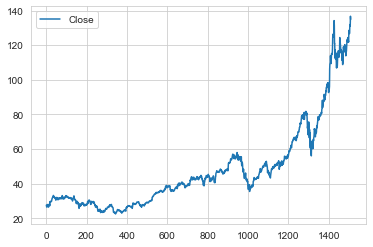

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
data = stock
plt.figure(figsize=(10, 5))
close_dataAAPL.plot()

In [45]:
data = data.reset_index()
x = np.array(data.index).reshape(-1, 1)
y = data['Close']

linreg = LinearRegression().fit(x, y)
linreg.score(x, y)
predictions = linreg.predict(x)

plt.figure(figsize=(15,5))
plt.plot(data['Close'])
plt.plot(data.index, predictions)

ValueError: cannot insert level_0, already exists

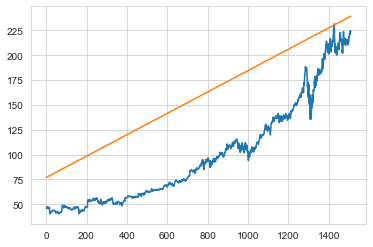

In [40]:
plt.plot(close_dataMSFT)
plt.plot(close_dataMSFT.index, predictions)

##Linear Regression optimization using polynomial

Best degree 7 with R^2: 0.9654743603351985 and RMSE: 4.627528837420729


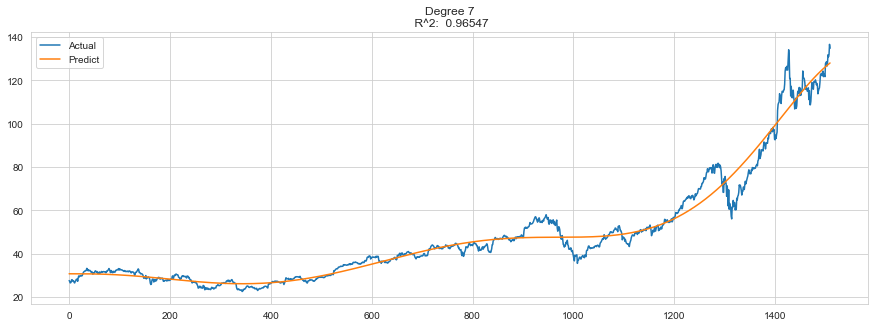

In [36]:
rmses = []
degrees = np.arange(1, 30)
r2, min_deg, min_rmse = 0, 0, 1e10

for deg in degrees:
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    x_poly = poly_features.fit_transform(x)
    poly_reg = LinearRegression()
    poly_reg.fit(x_poly, y)
    y_predict = poly_reg.predict(x_poly)
    poly_mse = mean_squared_error(y, y_predict)
    poly_rmse = np.sqrt(poly_mse)
    poly_r2 = r2_score(y, y_predict)
    #r2.append(poly_r2)
    rmses.append(poly_rmse)
    # Cross-validation of degree
    if min_rmse > poly_rmse :
        min_rmse = poly_rmse
        r2 = poly_r2
        min_deg = deg
        p = y_predict
print('Best degree {} with R^2: {} and RMSE: {}'.format(min_deg, r2, min_rmse))
plt.figure(figsize=(15,5))
plt.plot(data.index,y,label='Actual')
plt.plot(data.index,p,label='Predict')
plt.title('Degree {}\n R^2:  '.format(min_deg)+ str(round(r2,5)))
plt.legend()
plt.show()

# Load data and data split function (train,test)

In [ ]:
def data_load_and_train_test_split(company, start, end):
  '''
  Loads data from yfinance and splits into training, validation and testing sets

  Creates variables: stock, train, val and test
  '''
  global stock, close_data, train, test

  # load data and create a new index
  stock = yf.download(company, start, end)
  stock.reset_index(inplace=True)

  # create dataframe of 'Date' and 'Close'
  close_data = stock[['Date', 'Close']]

  # create splits 
  train = close_data[close_data['Date']< datetime.datetime(2020,1,1)]
  test = close_data[close_data['Date']> datetime.datetime(2020,1,1)]

  # remove 'Date' column so we are left with the 'Close' data
  close_data = close_data.filter(['Close'])
  train = train.filter(['Close'])
  test = test.filter(['Close'])

  return print('Orignal data shape:', stock.shape, '\n',
               'Close Dataframe shape:', close_data.shape, '\n',
               'Training set shape:', train.shape, '\n',
               'Testing set shape:', test.shape)

# ARIMA

In [ ]:
#example
company = 'MSFT'
start = "2015-01-01"
end="2020-12-30"
data_load_and_train_test_split(company,start,end)

[*********************100%***********************]  1 of 1 completed
Orignal data shape: (1509, 7) 
 Close Dataframe shape: (1509, 1) 
 Training set shape: (1258, 1) 
 Testing set shape: (251, 1)


## num diff

In [ ]:
# estimate the number of differencing.
def num_diff(stock):
  from pmdarima.arima.utils import ndiffs
  from statsmodels.compat.pandas import Appender
  kpss_diffs = ndiffs(stock, test='kpss')
  adf_diffs = ndiffs(stock, test="adf")
  return max(adf_diffs, kpss_diffs)

In [ ]:
#example
n_diffs = num_diff(close_data)

##check if stationary

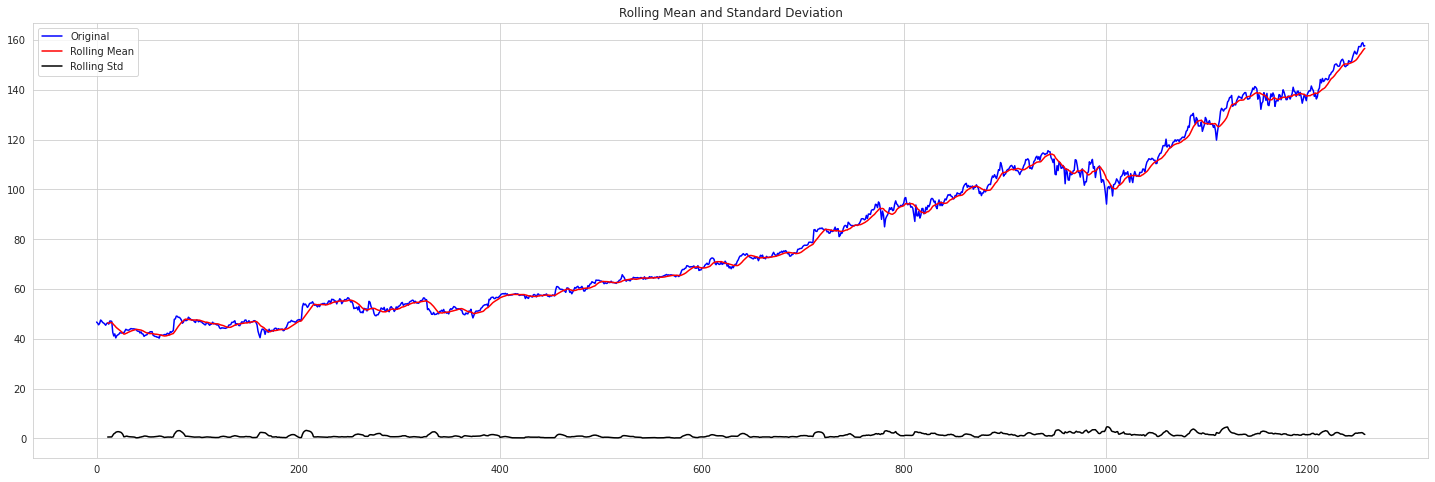

Results of dickey fuller test
Test Statistics                   2.130161
p-value                           0.998820
No. of lags used                  8.000000
Number of observations used    1249.000000
critical value (1%)              -3.435596
critical value (5%)              -2.863857
critical value (10%)             -2.568004
dtype: float64


In [ ]:
def test_stationarity(timeseries):
  '''
  Performs test statistics. If test statistics is bigger 
  than critical value and p-value is bigger than 0.05
  then this timeseries is not stationary
  '''
 #Determing rolling statistics
  rolmean = timeseries.rolling(12).mean()
  rolstd = timeseries.rolling(12).std()

  plt.plot(timeseries, color='blue',label='Original')
  plt.plot(rolmean, color='red', label='Rolling Mean')
  plt.plot(rolstd, color='black', label = 'Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean and Standard Deviation')
  plt.show(block=False)
  

  print('Results of dickey fuller test')
  adft = adfuller(timeseries,autolag='AIC')
  output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
  for key,values in adft[4].items():
    output['critical value (%s)'%key] = values
  print(output)
 
test_stationarity(train)

In [ ]:
# Define train_log for seasonality removal

train_log = train.apply(lambda x : np.log(x))

train_log.head()

,Close
0,3.845028
1,3.835790
2,3.821004
3,3.833629
4,3.862623


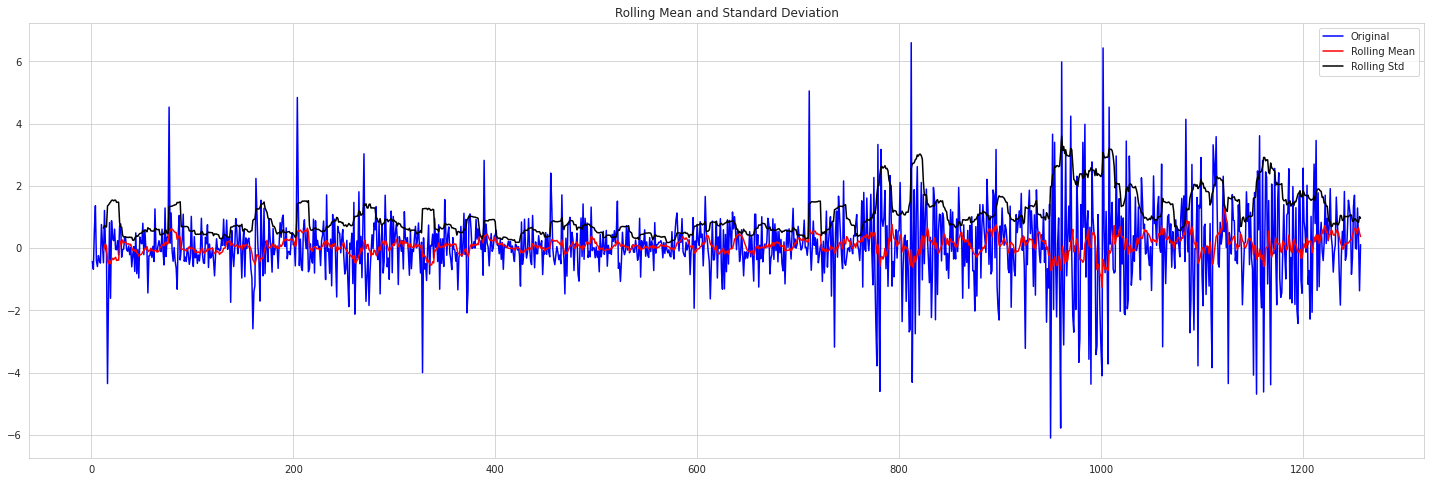

Results of dickey fuller test
Test Statistics               -1.502268e+01
p-value                        1.016923e-27
No. of lags used               7.000000e+00
Number of observations used    1.249000e+03
critical value (1%)           -3.435596e+00
critical value (5%)           -2.863857e+00
critical value (10%)          -2.568004e+00
dtype: float64


In [ ]:
# Remove seasonality
train_log_diff = train - train.shift(n_diffs) 
test_stationarity(train_log_diff.dropna())

## auto arima

In Auto ARIMA, the model itself will generate the optimal p, d, and q values which would be suitable for the data set to provide better forecasting

https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd

In [ ]:
def arima_auto(stock):
  from pmdarima.arima import auto_arima
  global arima_model
  arima_model = auto_arima(
      stock,
      start_p=0,
      start_q=0,
      test="adf",
      max_p=6,
      max_q=6,
      m=1,  # frequency of series
      d=n_diffs, 
      seasonal=False,  # no seasonality
      trace=True,
      stepwise=True,
      njob=-1,
  )
  print(arima_model.summary())
  return arima_model

In [ ]:
#example
arima_model = arima_auto(train_log_diff.dropna())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5060.539, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4691.157, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5058.539, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4435.694, Time=0.26 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4365.022, Time=0.30 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=4332.469, Time=0.46 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=4286.883, Time=0.54 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=4227.973, Time=0.72 sec


## arima model fit

In [ ]:
test[0:1]

In [ ]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',FutureWarning)

In [ ]:
#values
train = train.values

# Create list of x train values
history = [x for x in train]
# establish list for predictions
model_predictions = []
# Count number of test data points
N_test_observations = len(test)

# loop through every data point
for time_point in list(test.index):
    model = ARIMA(history, order=arima_model.order)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test[time_point-1258:time_point-1257]
    history.append(true_test_value)

In [ ]:
RMSE_error = np.sqrt(mean_squared_error(test, model_predictions))
print('Test Score: %.2f RMSE' % RMSE_error)

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(test.index[-100:], model_predictions[-100:], color='blue',label='Predicted Price')
plt.plot(test.index[-100:], test[-100:], color='red', label='Actual Price')
plt.title(company + ' Prices Prediction')
plt.ylabel('Prices')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

In [ ]:
plt.plot(train, label='training data')
plt.plot(test, label='actual price')
plt.plot(test.index[-len(test):],model_predictions[-len(test):], label='predicted price')
plt.ylabel('Price')
plt.title(company + ' Prices Prediction')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
import math
import plotly.graph_objects as go
from pylab import rcParams
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
rcParams['figure.figsize'] = 25, 8

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

valuessarima =close_data.values
train = train.values
test = test.values

result = seasonal_decompose(valuessarima, model='multiplicative', freq=365)
fig = result.plot()
plt.show()


In [ ]:
history = [x for x in train]
y = test

# Make first prediction
predictions = list()
model = ARIMA(train, order=(0, 1, 0))
model_fit = model.fit(disp=0)
yhat = model_fit.forecast()[0][0]
predictions.append(yhat)
history.append(y[0])

# Rolling forecasts
for i in range(1, len(y)):
     # Predict
     model = ARIMA(train, order=(0, 1, 0))
     model_fit = model.fit(disp=0)
     yhat = model_fit.forecast()[0][0]
     # Invert transformed prediction
     predictions.append(yhat)
     # Observation
     obs = y[i]
     history.append(obs)

# Report performance
mse = mean_squared_error(y, predictions)
print('MSE: ' + str(mse))
mae = mean_absolute_error(y, predictions)
print('MAE: ' + str(mae))
rmse = math.sqrt(mean_squared_error(y, predictions))
print('RMSE: ' + str(rmse))

In [ ]:
# Plotting ARIMA result
fig = go.Figure()

fig.add_trace(go.Scatter(x=train[-250:], y=train[250:], mode='lines', name='Price'))
fig.add_trace(go.Scatter(x=test, y=test, mode='lines', name='Test price'))
fig.add_trace(go.Scatter(x=test, y=predictions, mode='lines', name='Predicted price'))

fig.update_layout(autosize=True, width=1450, height=825,
    title_font=dict(size=25, family='Courier', color='crimson'),
    title="ARIMA prediction - Close Price",
)

fig.show()

# LSTM pre-processing 

same for all lstm models

In [ ]:
# functions used 

def supervised(data, num_timesteps=60, n_out = 1, dropnan = True):
  '''
  Converts time series into a supervised learning problem 
  '''
  # make data into a dataframe 
  data = pd.DataFrame(data)
  
  n_variables = 1 # i.e. number of features in this case we have chosen 'Close' 
  columns, names = list(),list()

  # input data
  for i in range(num_timesteps, 0, -1):
    columns.append(data.shift(i))
    names += [('var%d(t-%d')%(j+1,i) for j in range(n_variables)]

  # target data (forecast)
  for i in range(0, n_out):
    columns.append(data.shift(-i))
    if i ==0:
      names += [('var%d(t)' % (j+1)) for j in range(n_variables)]
    else:
      names += [('var%d(t+%d )' % (j+1, i)) for j in range(n_variables)]

  # combine the two
  df = pd.concat(columns, axis = 1)
  df.columns = names

  # drop missing data rows 
  if dropnan:
    df.dropna(inplace = True)

  return df


In [ ]:
#example
train = supervised(train)
train

In [ ]:

def split_and_reshape(data, num_timesteps=60, num_features=1):
  '''
  scales and reshapes data into required shape for LSTM in keras

  '''

 # get data values 
  values = data.values

  # split into x and y 
  X, y = values[:, :-1], values[:,-1]

  # reshape into 3D form
  X = np.reshape(X, (X.shape[0], num_timesteps, num_features ))

  
  print('X shape:',X.shape, '\ny shape:', y.shape)

  return X, y

In [ ]:
#example
X_train, y_train = split_and_reshape(train)

# LSTM  



In [ ]:
# Define optimiser and callbacks for all LSTMs
opt = Adam(0.0001)
callbacks = [ EarlyStopping(monitor='val_loss', mode='min', patience=10)]

#  Define Scaler 
scaler = MinMaxScaler(feature_range = (0,1))

In [ ]:
# Uses the same preprocessing as LSTM
#Example
company = 'AAPL'
start = "2015-01-01"
end="2020-12-30"
data_load_and_split(company,start,end)

In [ ]:
# Plotting performance 
# https://github.com/gcarq/keras-timeseries-prediction/blob/master/main.py
def plot_data(dataset: np.ndarray,
              company: str,
              measure: str,
              timestep: int,
              model_type:str,
              train_predict: np.ndarray,
              test_predict: np.ndarray,
              val_predict: np.ndarray):
             # forecast_predict=: np.ndarray):
    """
    Plots baseline and predictions
    Leaves gaps for the first time steps necessary for predictions
    light grey: baseline
    dashed black: prediction with training data
    dashed blue: prediction with test data
    dashed green: prediction based on predictions
    :param dataset: initial dataset
    :param company: name of company on the stock market,
    :param measure: names of measure studied,
    :param timestep: number of time steps necessary for prediction
    :param train_predict: predicted values based on training data
    :param test_predict: predicted values based on test data
    :param forecast_predict: predicted values based on previous predictions, default empty, 
    :return: None
    """
    plt.plot(dataset, color='lightgrey')
    plt.plot( [None for _ in range(timestep)] +
             [x for x in train_predict], '--', color='black')
    plt.plot([None for _ in range(timestep)] +
             # added for dimensionality, as length of train, val, and test sets 
             # does not include the first 'timesteps' for its predictions  
             [None for _ in range(timestep)] +
             [None for _ in train_predict] +
             [x for x in val_predict], '--', color='royalblue')
    plt.plot([None for _ in range(timestep)] +
             # added for dimensionality, as length of train, val, and test sets 
             # does not include the first 'timesteps' for its predictions  
             [None for _ in range(timestep)] + 
             [None for _ in train_predict] +
             # added for dimensionality, as length of train, val, and test sets 
             # does not include the first 'timesteps' for its predictions  
             [None for _ in range(timestep)] +
             [None for _ in val_predict] +
             [x for x in test_predict], '--', color='green')
    

    plt.title(f'{company} Stock Price Prediction using {model_type}')
    plt.xlabel('Time')
    plt.ylabel(f'{company} Stock Price')
    plt.legend(['dataset', 'train predict', 'train predict + val predict','train + val + test predict'])
    plt.show()

In [ ]:
#create training data
train_scaled = scaler.fit_transform(train)
train_supervised = supervised(train_scaled)
X_train, y_train = split_and_reshape(train_supervised)

# create validation data
val_scaled = scaler.fit_transform(val) 
val_supervised = supervised(val_scaled)
X_val, y_val = split_and_reshape(val_supervised)

# create test data
test_scaled = scaler.transform(test) # transform not fit_transform
test_supervised = supervised(test_scaled)
X_test, y_test = split_and_reshape(test_supervised)

In [ ]:

# test values for num_units 
#num_units = 50 
num_units = 128
#LSTM implementaiton
regressor = Sequential()
regressor.add(LSTM(units = num_units , return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = num_units , return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = num_units , return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = num_units ))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

regressor.compile(optimizer=opt, metrics=['mse', 'mae'], loss='mean_squared_error')
plot_model(regressor, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
# model summary and fit
regressor.summary()

history = regressor.fit(X_train, y_train, callbacks=callbacks, validation_data=(X_val,y_val),  epochs = 300, batch_size = 32)

In [ ]:
def get_predictions(model, X_train, X_val, X_test):
  '''
  Feeds data into pre-trained model and returns predictions
    :param model: compiled and trained model to be used for predictions
    :param X_train: training dataset X
    :param X_val: validation dataset X
    :param X_test: test dataset X
    :return:  train_predict: predictictions for training data
              test_predict: predictions for test data
              val_predict: predictions for validation data
  '''
  train_predict = model.predict(X_train)
  val_predict = model.predict(X_val)
  test_predict = model.predict(X_test)
  
  return train_predict, val_predict, test_predict


def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
  '''
  Obtain predictions, invert data and predictions, calculate metrics for evaluation
    :param model: compiled and trained model to be used for predictions
    :param X_train: training dataset X
    :param y_train: training dataset Y
    :param X_val: validation dataset X
    :param y_val: validation dataset y
    :param X_test: test dataset X
    :param y_test: test dataset y
  '''
  train_predict = model.predict(X_train)
  test_predict = model.predict(X_test)
  val_predict = model.predict(X_val)
  # invert dataset and predictions
  train_predict = scaler.inverse_transform(train_predict)
  train_y = scaler.inverse_transform([y_train])
  test_predict = scaler.inverse_transform(test_predict)
  test_y = scaler.inverse_transform([y_test])
  val_predict = scaler.inverse_transform(val_predict)
  val_y = scaler.inverse_transform([y_val])

  #forecast_predict = scaler.inverse_transform(forecast_predict)
  train_score = np.sqrt(mean_squared_error(train_y[0], train_predict[:, 0]))
  print('Train Score: %.2f RMSE' % train_score)
  test_score = np.sqrt(mean_squared_error(test_y[0], test_predict[:, 0]))
  print('Test Score: %.2f RMSE' % test_score)

In [ ]:
#need to include validation 
plot_data(close_data, companies=['AAPL'], timesteps=60, train_predict=train_predict,test_predict=test_predict,val_predict=val_predict)

# Stacked LSTM

In [ ]:
# Uses the same preprocessing as LSTM
#Example
company = 'AAPL'
start = "2015-01-01"
end="2020-12-30"

#load data 
data_load_and_split(company,start,end)

In [ ]:
# Scaling data 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

#create training data
train_scaled = scaler.fit_transform(train)
train_supervised = supervised(train_scaled)
X_train, y_train = split_and_reshape(train_supervised)

# create validation data
val_scaled = scaler.fit_transform(val) 
val_supervised = supervised(val_scaled)
X_val, y_val = split_and_reshape(val_supervised)

# create test data
test_scaled = scaler.transform(test) # transform not fit_transform
test_supervised = supervised(test_scaled)
X_test, y_test = split_and_reshape(test_supervised)

In [ ]:
# Create the stacked lstm model
model = Sequential()
model.add(LSTM(50, return_sequences=True,  input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mae', optimizer=opt, metrics=[ 'mse', 'mae'])
plot_model(regressor, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# model summary and fit
model.summary()
history = model.fit(X_train,y_train, callbacks=callbacksvalidation_data=(X_val,y_val), epochs=100,batch_size=64,verbose=1)

In [ ]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('loss ')
plt.legend()
plt.show()

In [ ]:
#predictions and check performance metrics
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
val_predict = model.predict(X_val)

# invert dataset and predictions
train_predict = scaler.inverse_transform(train_predict)
train_y = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
test_y = scaler.inverse_transform([y_test])
val_predict = scaler.inverse_transform(val_predict)
val_y = scaler.inverse_transform([y_val])

#forecast_predict = scaler.inverse_transform(forecast_predict)
train_score = np.sqrt(mean_squared_error(train_y[0], train_predict[:, 0]))
print('Train Score: %.2f RMSE' % train_score)
test_score = np.sqrt(mean_squared_error(test_y[0], test_predict[:, 0]))
print('Test Score: %.2f RMSE' % test_score)

In [ ]:
plot_data(close_data,look_back=60,train_predict=train_predict,test_predict=test_predict, val_predict=val_predict)

In [ ]:
#show actual and predicted price
plt.plot(inv_y,  label = company + ' actual close')
plt.plot(inv_test,  label = 'predicted')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
plt.plot(inv_y[:100], label = company + ' actual close')
plt.plot(inv_test[:100], label = 'predicted')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()

# Attention-Based LSTM

In [ ]:
data_load_and_split(company,start,end)

In [ ]:
close_data